In [1]:
import numpy as np

from online_cp import ConformalRidgeRegressor

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
rnd_gen = np.random.default_rng(2024)

N = 300
X = rnd_gen.normal(loc=0, scale=1, size=(N, 4))
beta = np.array([2, 1, 0, 0])
y = X @ beta + rnd_gen.normal(loc=0, scale=1, size=N)

In [3]:
def compute_p_value(y, precomputed, tau=None):
    A = precomputed['A']
    B = precomputed['B']
    if tau is None:
        tau = rnd_gen.uniform(0, 1)
    try:
        E = A + y*B

        Alpha = np.zeros_like(A)

        for i, e in enumerate(E):
            alpha = min((E >= e).sum(), (E<=e).sum())
            Alpha[i] = alpha

        alpha_y = Alpha[-1]
        gt = np.where(Alpha > alpha_y)[0].shape[0]
        eq = np.where(Alpha == alpha_y)[0].shape[0]

        p_y = (gt + tau * eq) / Alpha.size
    except TypeError:
        p_y = tau
    return p_y

def compute_upper_p_value(y, precomputed, tau=None):
    '''
    Computes the smoothed p-value of the example (x, y).
    Nonconformity scores are A + yB = y - yhat for upper CRR
    NOTE: This is the p-value for the upper CRR
    FIXME: Add possibility to compute lower p-value as well. (Are they equal?)
    Smoothed p-values can be used to test the exchangeability assumption.
    If X and XTXinv are passed, x must be the last row of X.
    '''
    if tau is None:
        tau = rnd_gen.uniform(0, 1)
    try:
        A = precomputed['A']
        B = precomputed['B']
        
        Alpha = A + y*B
        alpha_y = Alpha[-1]
        gt = np.where(Alpha > alpha_y)[0].shape[0]
        eq = np.where(Alpha == alpha_y)[0].shape[0]

        p_y = (gt + tau * eq) / Alpha.size
    except TypeError:
        p_y = tau
    return p_y

def compute_lower_p_value(y, precomputed, tau=None):
    '''
    Computes the smoothed p-value of the example (x, y).
    Nonconformity scores are A + yB = y - yhat for upper CRR
    NOTE: This is the p-value for the upper CRR
    FIXME: Add possibility to compute lower p-value as well. (Are they equal?)
    Smoothed p-values can be used to test the exchangeability assumption.
    If X and XTXinv are passed, x must be the last row of X.
    '''
    if tau is None:
        tau = rnd_gen.uniform(0, 1)
    try:
        A = precomputed['A']
        B = precomputed['B']
        Alpha = -(A + y*B)
        alpha_y = Alpha[-1]
        gt = np.where(Alpha > alpha_y)[0].shape[0]
        eq = np.where(Alpha == alpha_y)[0].shape[0]

        p_y = (gt + tau * eq) / Alpha.size
    except TypeError:
        p_y = tau
    return p_y

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

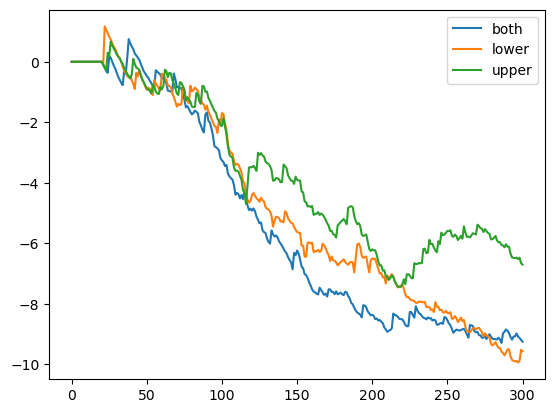

In [ ]:
from online_cp import PluginMartingale
from online_cp import ConformalRidgeRegressor
cp = ConformalRidgeRegressor(0.1, rnd_state=2025)


# from online_cp.regressors import KernelConformalRidgeRegressor
# from online_cp.kernels import LinearKernel, GaussianKernel

# ker = LinearKernel()

# kernel_a = 1
# cp = KernelConformalRidgeRegressor(a=kernel_a, kernel=ker, rnd_state=2025)

p_values = np.zeros((y.size, 3))

rnd_gen = np.random.default_rng(2025)

for i, (obj, lab) in tqdm(enumerate(zip(X, y)), total=y.size):

    _, precomputed = cp.predict(obj, return_update=True)

    tau = rnd_gen.uniform(0, 1)

    precomputed = None
    p = cp.compute_p_value(obj, lab, precomputed=precomputed, bounds='both', smoothed=False, tau=tau)
    p_lower = cp.compute_p_value(obj, lab, precomputed=precomputed, bounds='lower', smoothed=False, tau=tau)
    p_upper = cp.compute_p_value(obj, lab, precomputed=precomputed, bounds='upper', smoothed=False, tau=tau)

    p_values[i, 0] = p
    p_values[i, 1] = p_lower
    p_values[i, 2] = p_upper

    cp.learn_one(obj, lab, precomputed)   

M_lower = PluginMartingale()
M_upper = PluginMartingale()
M = PluginMartingale()

for row in tqdm(p_values):
    M_lower.update_martingale_value(row[1])
    M_upper.update_martingale_value(row[2])
    M.update_martingale_value(row[0])

plt.plot(M.log10_martingale_values, label='both')
plt.plot(M_lower.log10_martingale_values, label='lower')
plt.plot(M_upper.log10_martingale_values, label='upper')
plt.legend()

# To do
* Test the non-smoothed upper p-value against the formula given in ALRW. They must agree!
* The deviation when using the online update may be due to an implementation error, or nuemrical issues. Try to find out which it is!